# **3 - Classification tasks**

## **3.1.1 - MLP - Binary classification**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
data_path = '/content/drive/MyDrive/PRNN Assignment 2/multi_class_classification_data_group_25_train.txt'
data = np.genfromtxt(data_path, delimiter='\t', skip_header=1)

# Separate features and labels
X = data[:, :-1]  # All rows, all columns except the last one
y = data[:, -1].astype(int)  # Last column, convert to integer

In [ ]:
# Shuffle the dataset
np.random.seed(42)  # For reproducibility
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split the data
split_idx = int(0.8 * X.shape[0])  # 80% for training

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
def one_hot_encode(y):
    """
    Convert an array of labels to one-hot encoded format.
    """
    num_classes = np.unique(y).shape[0]
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# Convert labels to one-hot encoding
y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

In [ ]:
def normalize_features(X):
    """
    Normalize features to have mean=0 and std=1.
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

# Normalize training and testing sets
X_train_normalized = normalize_features(X_train)
X_test_normalized = normalize_features(X_test)

In [ ]:
class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, output_size, hidden_layers, loss_function, learning_rate=0.01, l1_reg=0.0, l2_reg=0.0):
        """
        Initializes the neural network with the given architecture, specified loss function, and learning rate.

        Parameters:
        - input_size (int): The size of the input layer (number of input features).
        - output_size (int): The size of the output layer (number of output classes or values).
        - hidden_layers (list): List of integers specifying the number of nodes in each hidden layer.
        - loss_function (str): String indicating the type of loss function to use ('mse' for mean squared error, etc.).
        - learning_rate (float): The learning rate for the training process. Default is 0.01.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.loss_function = loss_function
        self.learning_rate = learning_rate  # Set the learning rate here
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

        # Initialize network architecture
        self.weights = []  # List to store weights matrices
        self.biases = []   # List to store bias vectors
        self._initialize_weights_biases()

    def _initialize_weights_biases(self):
        """
        Initializes weights and biases for all layers in the network using small random values.
        """
        # Create a list of all layer sizes (input layer + hidden layers + output layer)
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weight matrix shape: (current layer size, next layer size)
            weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            # Bias vector shape: (next layer size,)
            bias_vector = np.zeros((layer_sizes[i+1],))

            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    def relu(self, Z):
        """
        Applies the ReLU activation function element-wise to the input array.
        """
        A = np.maximum(0, Z)
        # Debug: Print some statistics of the activations
        print("ReLU Activation - Max:", np.max(A), "Min:", np.min(A))
        return A

    def softmax(self, Z):
        """
        Applies the softmax function to each row of the input array.
        """
        shiftZ = Z - np.max(Z, axis=1, keepdims=True)  # Shift for numerical stability
        exps = np.exp(shiftZ)
        softmax_outputs = exps / np.sum(exps, axis=1, keepdims=True)
        # Debug: Print some statistics of the softmax outputs
        print("Softmax Output - Max:", np.max(softmax_outputs), "Min:", np.min(softmax_outputs), "Sum (first example):", np.sum(softmax_outputs[0]))
        return softmax_outputs

    def forward_pass(self, X):
        """
        Performs the forward pass through the network and returns the output.

        Parameters:
        - X (np.array): Input data array (batch size, input_size).

        Returns:
        - np.array: The output of the network after passing through all layers.
        """
        A = X  # Initialize A with the input; A will hold the output of the current layer
        activations = []  # List to store intermediate activations for use in backpropagation

        # Iterate through all layers except the last one
        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]  # Compute the linear combination
            A = self.relu(Z)  # Apply ReLU activation function
            activations.append(A)  # Store the activation for later use

        # Last layer (output layer)
        Z_final = np.dot(A, self.weights[-1]) + self.biases[-1]
        if self.loss_function == 'crossentropy':
            # Use softmax for classification tasks
            A_final = self.softmax(Z_final)
        else:
            # For regression tasks (or other tasks not using softmax), apply a linear activation
            A_final = Z_final  # Linear activation for the output layer

        activations.append(A_final)  # Store final activation

        return A_final, activations

    def compute_loss(self, predicted, actual):
        """
        Computes the loss using the specified loss function, adding L1 and L2 regularization penalties.

        Parameters:
        - predicted (np.array): Predicted probabilities or values from the forward pass.
        - actual (np.array): Actual labels (for classification) or values (for regression).

        Returns:
        - float: The computed loss, including regularization penalties.
        """
        m = actual.shape[0]  # Number of examples
        # Base loss calculation
        if self.loss_function == 'crossentropy':
          log_probs = -np.log(predicted[range(m), actual.argmax(axis=1)])
          base_loss = np.sum(log_probs) / m
        elif self.loss_function == 'mse':
          base_loss = np.sum((predicted - actual) ** 2) / m
        else:
          raise ValueError("Unsupported loss function specified.")

        # L1 Regularization
        l1_loss = 0
        if self.l1_reg > 0:
          l1_loss = np.sum([np.sum(np.abs(w)) for w in self.weights])

        # L2 Regularization
        l2_loss = 0
        if self.l2_reg > 0:
          l2_loss = np.sum([np.sum(w ** 2) for w in self.weights])

        # Total loss with L1 and L2 regularization
        total_loss = base_loss + (self.l1_reg * l1_loss) + (self.l2_reg * l2_loss) / (2 * m)

        return total_loss


    def backpropagate(self, input_data, actual, activations):
        """
        Performs backpropagation and updates weights and biases based on the computed gradients,
        including L1 and L2 regularization adjustments.

        Parameters:
        - input_data (np.array): Input data batch.
        - actual (np.array): Actual labels for classification or values for regression.
        - activations (list): List of activations from the forward pass.
        """
        gradients = []  # To store gradients for weights and biases
        m = actual.shape[0]  # Number of examples

        # Start with the gradient of the loss w.r.t. the final activation
        if self.loss_function == 'crossentropy':
            delta = activations[-1] - actual
        elif self.loss_function == 'mse':
            delta = (activations[-1] - actual) * 1

        for i in reversed(range(len(self.weights))):
            A_prev = input_data if i == 0 else activations[i-1]

            # Compute gradients with L2 regularization adjustment
            dW = np.dot(A_prev.T, delta) / m + (self.l2_reg * self.weights[i]) / m
            db = np.sum(delta, axis=0) / m
            # Debug: Print some statistics of the gradients
            print(f"Layer {i} - Gradient Weights Max:", np.max(dW), "Min:", np.min(dW))

            # Prepare for next layer's backpropagation, if not at the input layer
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * (A_prev > 0)  # Assuming ReLU activation

            gradients.append((dW, db))

        # Update weights and biases, including L1 regularization handling
        for i in range(len(self.weights)):
            dW, db = gradients[-1-i]

            # L1 regularization adjustment for weights update
            # This simplistic approach adjusts weights directly, simulating sub-gradient for L1
            if self.l1_reg > 0:
                dW += (self.l1_reg * np.sign(self.weights[i])) / m

            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

In [ ]:

model = FullyConnectedNeuralNetwork(
    input_size=X_train_normalized.shape[1],
    output_size=y_train_one_hot.shape[1],
    hidden_layers=[32],
    loss_function='crossentropy',
    learning_rate=0.05
)

In [ ]:
def train(model, X_train, y_train, X_test, y_test, epochs=10000001):
    training_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Forward pass
        predictions, activations = model.forward_pass(X_train)

        # Compute loss
        loss = model.compute_loss(predictions, y_train)
        training_losses.append(loss)

        # Backpropagation
        model.backpropagate(X_train, y_train, activations)

        # Compute test accuracy
        test_predictions, _ = model.forward_pass(X_test)
        test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1))
        test_accuracies.append(test_accuracy)

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss}, Test Accuracy: {test_accuracy}")

    return training_losses, test_accuracies

In [ ]:
training_losses, test_accuracies = train(
    model=model,
    X_train=X_train_normalized,
    y_train=y_train_one_hot,
    X_test=X_test_normalized,
    y_test=y_test_one_hot,
    epochs=1000
)

Streaming output truncated to the last 5000 lines.
Layer 1 - Gradient Weights Max: 0.012335746350370127 Min: -0.012335746350370127
Layer 0 - Gradient Weights Max: 0.008295707042487142 Min: -0.006586711168525786
ReLU Activation - Max: 0.33394233986189137 Min: 0.0
Softmax Output - Max: 0.5283392279491785 Min: 0.47166077205082146 Sum (first example): 1.0
Epoch 180, Loss: 0.6869519771384078, Test Accuracy: 0.6975
ReLU Activation - Max: 0.3637168876308329 Min: 0.0
Softmax Output - Max: 0.5308292044354913 Min: 0.46917079556450864 Sum (first example): 1.0
Layer 1 - Gradient Weights Max: 0.012446132835886288 Min: -0.012446132835886288
Layer 0 - Gradient Weights Max: 0.008397427102895866 Min: -0.006645734710809468
ReLU Activation - Max: 0.33695792825033255 Min: 0.0
Softmax Output - Max: 0.5287989044437681 Min: 0.47120109555623196 Sum (first example): 0.9999999999999999
ReLU Activation - Max: 0.36701405960049227 Min: 0.0
Softmax Output - Max: 0.5313413888735269 Min: 0.46865861112647306 Sum (firs

In [ ]:
def predict(model, X):
    """
    Predicts the class labels for the given input X using the model.

    Parameters:
    - model: An instance of the FullyConnectedNeuralNetwork class.
    - X: Input data, a Numpy array of shape (n_samples, n_features).

    Returns:
    - predictions: An array of predicted class labels.
    """
    softmax_outputs, _ = model.forward_pass(X)
    predictions = np.argmax(softmax_outputs, axis=1)
    return predictions

def calculate_accuracy(predictions, y_true):
    """
    Calculates the accuracy given predictions and true labels.

    Parameters:
    - predictions: An array of predicted class labels.
    - y_true: True class labels, a Numpy array of shape (n_samples, ).
              Assumes y_true is not one-hot encoded.

    Returns:
    - accuracy: Classification accuracy as a float.
    """
    y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot encoding to class labels
    accuracy = np.mean(predictions == y_true_labels)
    return accuracy

# Use the predict function to get predictions for training and test sets
train_predictions = predict(model, X_train_normalized)
test_predictions = predict(model, X_test_normalized)

# Calculate accuracy
train_accuracy = calculate_accuracy(train_predictions, y_train_one_hot)
test_accuracy = calculate_accuracy(test_predictions, y_test_one_hot)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

ReLU Activation - Max: 2.641272872749901 Min: 0.0
Softmax Output - Max: 0.9888474012320201 Min: 0.011152598767979818 Sum (first example): 1.0
ReLU Activation - Max: 2.4434907743479566 Min: 0.0
Softmax Output - Max: 0.9773657914749654 Min: 0.02263420852503468 Sum (first example): 1.0
Training Accuracy: 71.88%
Test Accuracy: 72.32%


In [ ]:
def confusion_matrix(y_true, predictions, num_classes):
    """
    Constructs a confusion matrix.

    Parameters:
    - y_true: True class labels, a Numpy array of shape (n_samples, ). Assumes labels are integers.
    - predictions: Predicted class labels, a Numpy array of shape (n_samples, ).
    - num_classes: The number of classes.

    Returns:
    - cm: The confusion matrix, a 2D Numpy array of shape (num_classes, num_classes).
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, predicted_label in zip(y_true, predictions):
        cm[true_label, predicted_label] += 1
    return cm

y_test_labels = np.argmax(y_test_one_hot, axis=1)  # Convert one-hot encoding to class labels

# Number of classes
num_classes = y_test_one_hot.shape[1]

# Generate confusion matrix for the test set
test_cm = confusion_matrix(y_test_labels, test_predictions, num_classes)

# Print the confusion matrix
print("Confusion Matrix for the Test Set:")
print(test_cm)

Confusion Matrix for the Test Set:
[[1052  403]
 [ 372  973]]


In [ ]:
def classwise_f1_scores(confusion_matrix):
    """
    Calculates F1 scores for each class based on the confusion matrix.

    Parameters:
    - confusion_matrix: The confusion matrix as a 2D Numpy array.

    Returns:
    - f1_scores: A Numpy array containing the F1 score for each class.
    """
    num_classes = confusion_matrix.shape[0]
    f1_scores = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_scores[i] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_scores

f1_scores = classwise_f1_scores(test_cm)

# Print class-wise F1 scores
for i, score in enumerate(f1_scores):
    print(f"Class {i}: F1 Score = {score:.4f}")

Class 0: F1 Score = 0.7308
Class 1: F1 Score = 0.7152


ReLU Activation - Max: 2.4434907743479566 Min: 0.0
Softmax Output - Max: 0.9773657914749654 Min: 0.02263420852503468 Sum (first example): 1.0


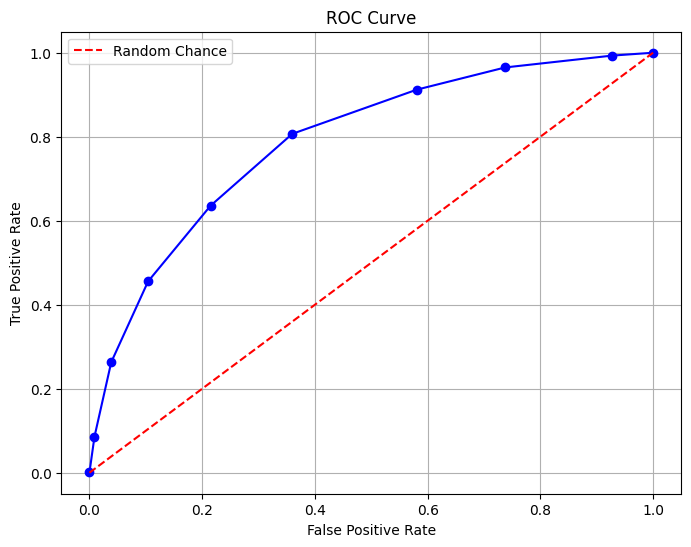

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_tpr_fpr(y_true, scores, threshold):
    """
    Compute True Positive Rate and False Positive Rate for a given threshold.
    """
    # Predict positive if score >= threshold
    predictions = (scores >= threshold).astype(int)

    tp = np.sum((y_true == 1) & (predictions == 1))
    fn = np.sum((y_true == 1) & (predictions == 0))
    fp = np.sum((y_true == 0) & (predictions == 1))
    tn = np.sum((y_true == 0) & (predictions == 0))

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return tpr, fpr

# Class 0 is the "positive" class
y_true_binary = (np.argmax(y_test_one_hot, axis=1) == 0).astype(int)
scores = model.forward_pass(X_test_normalized)[0][:, 0]  # Softmax scores for class 0

# Select 10 thresholds spaced across the score range
thresholds = np.linspace(scores.min(), scores.max(), 10)
tprs = []
fprs = []

for threshold in thresholds:
    tpr, fpr = compute_tpr_fpr(y_true_binary, scores, threshold)
    tprs.append(tpr)
    fprs.append(fpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprs, tprs, marker='o', linestyle='-', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

Now doing it for MSE loss function

In [ ]:
model_mse = FullyConnectedNeuralNetwork(
    input_size=X_train_normalized.shape[1],  # Number of input features
    output_size=y_train_one_hot.shape[1],    # Number of output classes
    hidden_layers=[32],                      # Example: simplified model with one hidden layer of 32 neurons
    loss_function='mse',                     # Using Mean Squared Error as the loss function
    learning_rate=0.05                       # Learning rate
)

In [ ]:
def train_mse(model, X_train, y_train, X_test, y_test, epochs=100):
    training_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Forward pass
        predictions, _ = model.forward_pass(X_train)

        # Compute loss using MSE
        loss = model.compute_loss(predictions, y_train)
        training_losses.append(loss)

        # Backpropagation to update weights
        model.backpropagate(X_train, y_train, _)

        # Compute accuracy on the test set
        test_predictions, _ = model.forward_pass(X_test)
        test_predicted_classes = np.argmax(test_predictions, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)
        test_accuracy = np.mean(test_predicted_classes == y_test_classes)
        test_accuracies.append(test_accuracy)

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return training_losses, test_accuracies

training_losses_mse, test_accuracies_mse = train_mse(
    model=model_mse,
    X_train=X_train_normalized,
    y_train=y_train_one_hot,
    X_test=X_test_normalized,
    y_test=y_test_one_hot,
    epochs=1000
)

ReLU Activation - Max: 0.2019943069868658 Min: 0.0
Layer 1 - Gradient Weights Max: -0.003551642693575914 Min: -0.011091351975374919
Layer 0 - Gradient Weights Max: 0.004176370279166576 Min: -0.003217224811177584
ReLU Activation - Max: 0.1780454791443938 Min: 0.0
Epoch 0, Loss: 1.0011, Test Accuracy: 0.4196
ReLU Activation - Max: 0.20259006139697944 Min: 0.0
Layer 1 - Gradient Weights Max: -0.0032024576351233247 Min: -0.01062256603618147
Layer 0 - Gradient Weights Max: 0.004042279423125034 Min: -0.0031576045515993786
ReLU Activation - Max: 0.17727783179988524 Min: 0.0
ReLU Activation - Max: 0.2032014576960629 Min: 0.0
Layer 1 - Gradient Weights Max: -0.002879144695372172 Min: -0.010183869944946602
Layer 0 - Gradient Weights Max: 0.003909217880912611 Min: -0.003076838086422487
ReLU Activation - Max: 0.17658423745305263 Min: 0.0
ReLU Activation - Max: 0.20382463322945135 Min: 0.0
Layer 1 - Gradient Weights Max: -0.0025791534049588558 Min: -0.00977264367162106
Layer 0 - Gradient Weights Ma

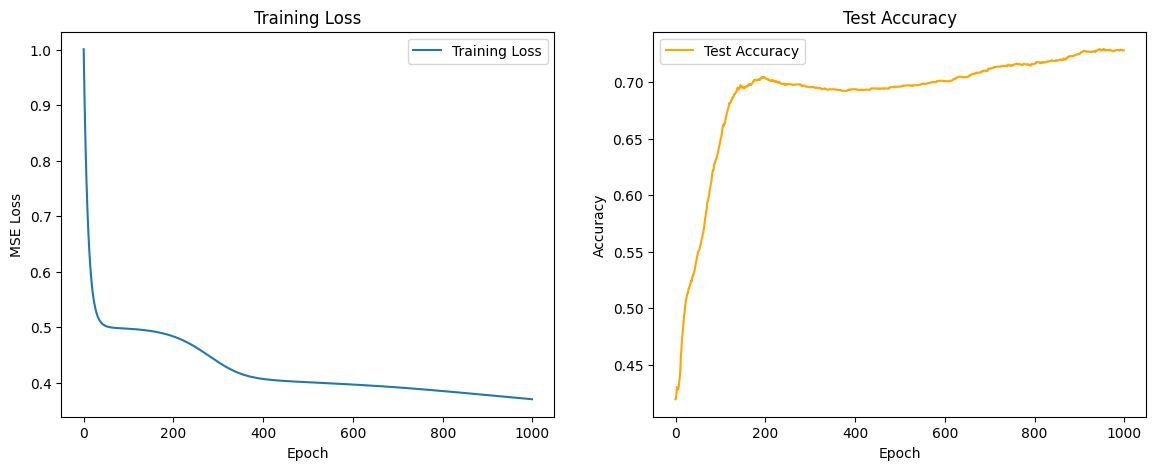

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses_mse, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies_mse, label='Test Accuracy', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Function to compute the confusion matrix
def compute_confusion_matrix(true, preds, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, predicted_label in zip(true, preds):
        cm[true_label, predicted_label] += 1
    return cm

# `y_test_one_hot` is your ground truth in one-hot format
y_test_classes = np.argmax(y_test_one_hot, axis=1)  # Convert from one-hot to class indices

# Check if `test_predictions` needs conversion from scores to class indices
if test_predictions.ndim > 1 and test_predictions.shape[1] > 1:
    # If `test_predictions` is 2D with shape [num_samples, num_classes], convert scores to class indices
    test_predicted_classes = np.argmax(test_predictions, axis=1)
else:
    # If `test_predictions` is already class indices, use it directly
    test_predicted_classes = test_predictions

# number of classes can be derived from `y_test_one_hot`
num_classes = y_test_one_hot.shape[1]

# Compute the confusion matrix
confusion_mat = compute_confusion_matrix(y_test_classes, test_predicted_classes, num_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[1052  403]
 [ 372  973]]


In [ ]:
def calculate_classwise_f1(confusion_mat):
    """
    Calculates class-wise F1 scores from the confusion matrix.

    Parameters:
    - confusion_mat: The confusion matrix as a 2D Numpy array.

    Returns:
    - f1_scores: A list containing the F1 score for each class.
    """
    num_classes = confusion_mat.shape[0]
    f1_scores = []

    for i in range(num_classes):
        TP = confusion_mat[i, i]
        FP = np.sum(confusion_mat[:, i]) - TP
        FN = np.sum(confusion_mat[i, :]) - TP
        TN = np.sum(confusion_mat) - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        f1_scores.append(f1_score)

    return f1_scores

# 'confusion_mat' is previously computed confusion matrix
f1_scores = calculate_classwise_f1(confusion_mat)

# Print the F1 scores for each class
for i, score in enumerate(f1_scores):
    print(f"Class {i}: F1 Score = {score:.4f}")

Class 0: F1 Score = 0.7308
Class 1: F1 Score = 0.7152


## **3.1.2 - MLP - Multiclass classification**

In [ ]:
import numpy as np

# Define the path to your file
file_path = '/content/drive/MyDrive/PRNN Assignment 2/multi_class_classification_data_group_25_train2.txt'

# Load the text file
with open(file_path, 'r') as file:
    # Read the lines in the file
    lines = file.readlines()

# Process the lines to split them into features and labels
data = np.array([line.strip().split('\t') for line in lines[1:]])  # Skip header and split each line

# Separate features and labels
X = data[:, :-1].astype(float)  # Convert features to float, corrected from np.float to float
y = data[:, -1].astype(int)  # Convert labels to int, corrected from np.int to int

# Check the shapes of features and labels
print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Features shape: (70000, 25)
Labels shape: (70000,)


In [ ]:
# Shuffle the data
np.random.seed(42)  # For reproducibility
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

# Define the size of the training set (e.g., 80% of the dataset)
train_size = int(0.8 * len(X))

# Split the data
X_train, X_test = X_shuffled[:train_size], X_shuffled[train_size:]
y_train, y_test = y_shuffled[:train_size], y_shuffled[train_size:]

# Verify the size of the splits
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (56000, 25) (56000,)
Testing set size: (14000, 25) (14000,)


In [ ]:
# Assuming y_train and y_test are your label vectors

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

# Normalize features
X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_normalized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

In [ ]:
# Neural network architecture parameters
input_size = X_train_normalized.shape[1]  # Number of features
output_size = y_train_encoded.shape[1]  # Number of classes (10 if you have labels 0-9)
hidden_layers = [64, 32]  # two hidden layers with 64 and 32 neurons
loss_function = 'crossentropy'  # Using cross-entropy loss for classification
learning_rate = 0.01  # Example learning rate

# Initialize the neural network
nn_model = FullyConnectedNeuralNetwork(input_size=input_size,
                                        output_size=output_size,
                                        hidden_layers=hidden_layers,
                                        loss_function=loss_function,
                                        learning_rate=learning_rate)

# Perform a forward pass with a batch of your training data
output, activations = nn_model.forward_pass(X_train_normalized[:32])  # Example with a batch of 32

# Compute the loss for this batch
loss = nn_model.compute_loss(output, y_train_encoded[:32])

print("Initial loss:", loss)

ReLU Activation - Max: 0.1795178584339259 Min: 0.0
ReLU Activation - Max: 0.010229069903401547 Min: 0.0
Softmax Output - Max: 0.10004470231803755 Min: 0.09996439532580803 Sum (first example): 1.0
Initial loss: 2.3025687083603747


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    m = X_train.shape[0]
    n_batches = m // batch_size

    training_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        for i in range(n_batches):
            batch_start, batch_end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[batch_start:batch_end], y_train[batch_start:batch_end]

            # Forward pass
            output, activations = model.forward_pass(X_batch)

            # Compute loss
            loss = model.compute_loss(output, y_batch)
            epoch_losses.append(loss)

            # Backpropagation and weight update
            model.backpropagate(X_batch, y_batch, activations)

        # Store the average loss for this epoch
        training_losses.append(np.mean(epoch_losses))

        # Evaluate the model on the test set after each epoch
        test_accuracy = evaluate_model(model, X_test, y_test)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {training_losses[-1]:.4f} - Test Accuracy: {test_accuracy:.4f}")

    return training_losses, test_accuracies

def evaluate_model(model, X_test, y_test):
    # Perform a forward pass with the test set
    output, _ = model.forward_pass(X_test)
    predictions = np.argmax(output, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(predictions == true_labels)
    return accuracy

In [ ]:
epochs = 100  # Number of epochs to train for
batch_size = 64  # Size of the batch

# Training the model
training_losses, test_accuracies = train_model(nn_model, X_train_normalized, y_train_encoded, X_test_normalized, y_test_encoded, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
Softmax Output - Max: 0.9888558822818466 Min: 6.658540482849204e-06 Sum (first example): 0.9999999999999999
Layer 2 - Gradient Weights Max: 0.07671964129313807 Min: -0.11282267955538647
Layer 1 - Gradient Weights Max: 0.15366244472147375 Min: -0.13886610722356857
Layer 0 - Gradient Weights Max: 0.2402392235423777 Min: -0.17405789367661298
ReLU Activation - Max: 5.361928068051118 Min: 0.0
ReLU Activation - Max: 4.899752957162492 Min: 0.0
Softmax Output - Max: 0.9430128222879552 Min: 9.479463726599895e-06 Sum (first example): 1.0000000000000002
Layer 2 - Gradient Weights Max: 0.0921457698002561 Min: -0.16123242655961995
Layer 1 - Gradient Weights Max: 0.1713189924425376 Min: -0.28689758434600776
Layer 0 - Gradient Weights Max: 0.17544320360336926 Min: -0.15875497291677873
ReLU Activation - Max: 5.964669539867933 Min: 0.0
ReLU Activation - Max: 3.6536469411827617 Min: 0.0
Softmax Output - Max: 0.9596894759889121 Min: 5.120234495324526e-05

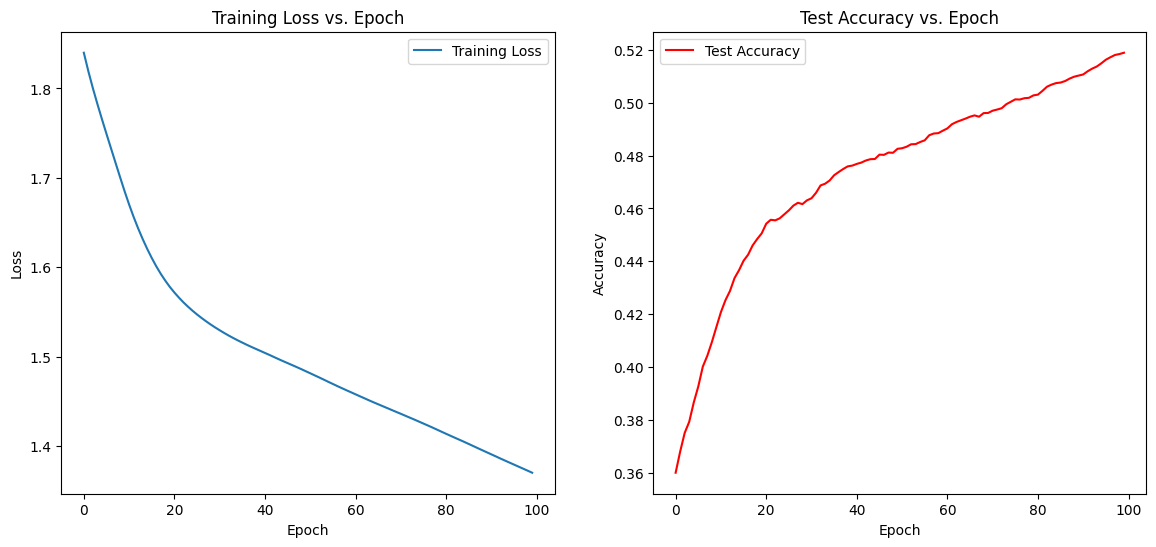

In [ ]:
plt.figure(figsize=(14, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs. Epoch')
plt.legend()

plt.show()

In [ ]:
def get_predictions(model, X):
    """
    Perform a forward pass using the model and return the predicted labels.

    Parameters:
    - model: The trained neural network model.
    - X: The input features (normalized).

    Returns:
    - predictions: The predicted class labels as integers.
    """
    # Get the output probabilities from the model
    output, _ = model.forward_pass(X)
    # Convert probabilities to class labels
    predictions = np.argmax(output, axis=1)
    return predictions

def compute_confusion_matrix(true_labels, predictions, num_classes):
    """
    Computes the confusion matrix.

    Parameters:
    - true_labels: The true labels as integers.
    - predictions: The predicted labels as integers.
    - num_classes: The number of classes.

    Returns:
    - cm: The confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(true_labels, predictions):
        cm[true, pred] += 1
    return cm


true_labels = np.argmax(y_test_encoded, axis=1)  # Convert one-hot encoded labels back to integers
predictions = get_predictions(nn_model, X_test_normalized)

# Assuming the number of classes is 10 (for labels 0-9)
num_classes = 10
confusion_matrix = compute_confusion_matrix(true_labels, predictions, num_classes)

print("Confusion Matrix:")
print(confusion_matrix)

ReLU Activation - Max: 8.482527859232203 Min: 0.0
ReLU Activation - Max: 5.698972910274555 Min: 0.0
Softmax Output - Max: 0.9975703641601107 Min: 1.5073018120835292e-07 Sum (first example): 1.0000000000000002
Confusion Matrix:
[[734  55  86  91  79  93  49  70  63  58]
 [ 87 756  71  56  96  83  83  55  68  74]
 [ 84  69 723  66  69  83  95  98  84  68]
 [ 86  49  89 648  71  94 112  83  82  73]
 [ 84  66  87  69 729  57  81  99  86  59]
 [ 77  68  68  56  63 826  60  68  63  62]
 [ 59  75  91  76  89  72 604  79  84 100]
 [ 65  38  83  80  85  71  77 774  83 100]
 [ 77  45  78  70  79  82  61  69 732  54]
 [ 61  57  69  64  67  87  92 107  64 739]]


In [ ]:
def calculate_f1_scores(cm):
    """
    Calculates F1 scores for each class given a confusion matrix.

    Parameters:
    - cm: The confusion matrix

    Returns:
    - f1_scores: A list of F1 scores for each class.
    """
    num_classes = cm.shape[0]
    f1_scores = []

    for i in range(num_classes):
        # True positives
        tp = cm[i, i]
        # False positives: sum of column i (excluding tp)
        fp = np.sum(cm[:, i]) - tp
        # False negatives: sum of row i (excluding tp)
        fn = np.sum(cm[i, :]) - tp
        # Precision and recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    return f1_scores

f1_scores = calculate_f1_scores(confusion_matrix)
class_labels = [f'Class {i}' for i in range(num_classes)]

# Print F1 scores for each class
for label, score in zip(class_labels, f1_scores):
    print(f'{label}: F1 Score = {score:.4f}')

Class 0: F1 Score = 0.5258
Class 1: F1 Score = 0.5586
Class 2: F1 Score = 0.5014
Class 3: F1 Score = 0.4867
Class 4: F1 Score = 0.5127
Class 5: F1 Score = 0.5583
Class 6: F1 Score = 0.4571
Class 7: F1 Score = 0.5233
Class 8: F1 Score = 0.5312
Class 9: F1 Score = 0.5290


Model with MSE

In [ ]:
# Initialize the new neural network model with MSE loss
nn_model_mse = FullyConnectedNeuralNetwork(input_size=input_size,
                                           output_size=output_size,
                                           hidden_layers=hidden_layers,
                                           loss_function='mse',  # Changed to 'mse'
                                           learning_rate=learning_rate)


In [ ]:
def train_model_mse(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    m = X_train.shape[0]
    n_batches = m // batch_size

    training_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        for i in range(n_batches):
            batch_start, batch_end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[batch_start:batch_end], y_train[batch_start:batch_end]

            # Forward pass
            output, activations = model.forward_pass(X_batch)

            # Compute loss specifically for MSE
            loss = model.compute_loss(output, y_batch)
            epoch_losses.append(loss)

            # Backpropagation and weight update
            model.backpropagate(X_batch, y_batch, activations)

        # Store the average loss for this epoch
        training_losses.append(np.mean(epoch_losses))

        print(f"Epoch {epoch+1}/{epochs} - Loss: {training_losses[-1]:.4f}")

    return training_losses  # Adjusted to focus on loss

In [ ]:
# Epochs and batch_size are defined as before
training_losses_mse = train_model_mse(nn_model_mse, X_train_normalized, y_train_encoded, X_test_normalized, y_test_encoded, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
Layer 2 - Gradient Weights Max: 0.02053270542638156 Min: -0.02559590702546742
Layer 1 - Gradient Weights Max: 0.018598804950190378 Min: -0.021270663345669325
Layer 0 - Gradient Weights Max: 0.04048536685086043 Min: -0.034955154987785196
ReLU Activation - Max: 1.3125333577193763 Min: 0.0
ReLU Activation - Max: 0.6315486682678305 Min: 0.0
Layer 2 - Gradient Weights Max: 0.01026188200039001 Min: -0.020447046647262688
Layer 1 - Gradient Weights Max: 0.01783288973784695 Min: -0.02198841470630543
Layer 0 - Gradient Weights Max: 0.024615739782494567 Min: -0.027971588579468645
ReLU Activation - Max: 1.8392430230727128 Min: 0.0
ReLU Activation - Max: 0.6210224910574986 Min: 0.0
Layer 2 - Gradient Weights Max: 0.014588347295126154 Min: -0.013609061663349117
Layer 1 - Gradient Weights Max: 0.021826643619049742 Min: -0.02152044335401278
Layer 0 - Gradient Weights Max: 0.030781043382160346 Min: -0.024562794237177273
ReLU Activation - Max: 1.3936380

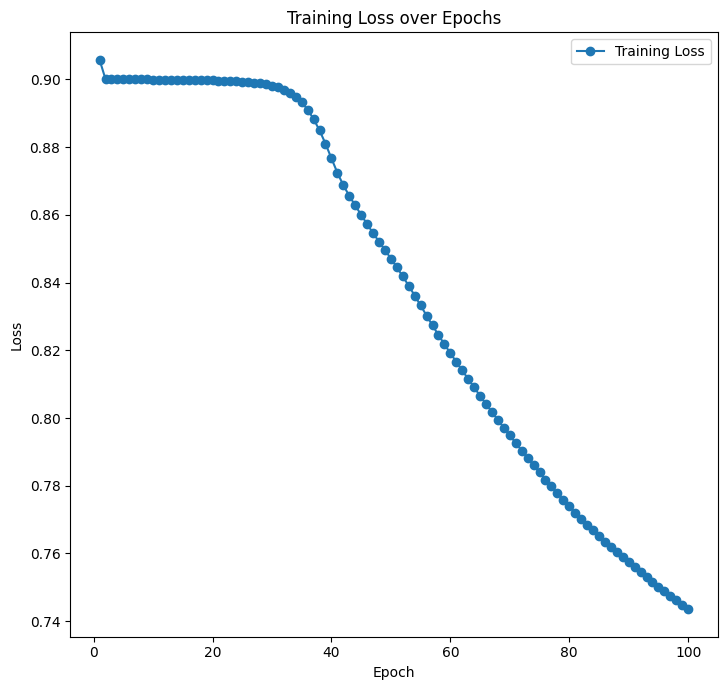

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(training_losses_mse) + 1)

# Plot training loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses_mse, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, test_accuracies_mse, label='Test Accuracy', color='red', marker='o')  # Assuming test_accuracies_mse exists
# plt.title('Test Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def calculate_accuracy_mse_thresholding(model, X_test, y_test):
    """
    Calculates accuracy for the test set using MSE outputs and thresholding for classification.

    Parameters:
    - model: The trained neural network model.
    - X_test: Test set features (normalized).
    - y_test: True labels for the test set, one-hot encoded.

    Returns:
    - accuracy: The classification accuracy on the test set.
    """
    predictions_continuous, _ = model.forward_pass(X_test)  # Model outputs continuous values
    predictions = np.argmax(predictions_continuous, axis=1)  # Classify as the highest output value
    true_labels = np.argmax(y_test, axis=1)  # True labels

    # Calculate accuracy
    correct_predictions = np.sum(predictions == true_labels)
    total_predictions = predictions.shape[0]
    accuracy = correct_predictions / total_predictions

    return accuracy

# Assuming nn_model_mse is your trained model with MSE loss
final_accuracy = calculate_accuracy_mse_thresholding(nn_model_mse, X_test_normalized, y_test_encoded)
print(f"Final Model Accuracy (with thresholding): {final_accuracy:.4f}")

ReLU Activation - Max: 2.2220450000903655 Min: 0.0
ReLU Activation - Max: 0.8803252085964569 Min: 0.0
Final Model Accuracy (with thresholding): 0.4274


In [ ]:
def get_predictions_mse_thresholding(model, X):
    """
    Get class predictions for the dataset using the model with MSE loss and thresholding.

    Parameters:
    - model: The trained model.
    - X: The input features (normalized).

    Returns:
    - predictions: The predicted class labels as integers.
    """
    predictions_continuous, _ = model.forward_pass(X)  # Continuous outputs from the model
    predictions = np.argmax(predictions_continuous, axis=1)  # Highest output value as the predicted class
    return predictions

def compute_confusion_matrix(true_labels, predictions, num_classes):
    """
    Computes the confusion matrix.

    Parameters:
    - true_labels: The true class labels as integers.
    - predictions: The predicted class labels as integers.
    - num_classes: The number of classes.

    Returns:
    - cm: The confusion matrix as a 2D numpy array.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(true_labels, predictions):
        cm[true, pred] += 1
    return cm

# nn_model_mse is trained model, and X_test_normalized and y_test_encoded are test datasets
predictions = get_predictions_mse_thresholding(nn_model_mse, X_test_normalized)
true_labels = np.argmax(y_test_encoded, axis=1)  # Convert one-hot encoded labels back to integers

# Compute confusion matrix
num_classes = 10
confusion_matrix = compute_confusion_matrix(true_labels, predictions, num_classes)

print("Confusion Matrix:")
print(confusion_matrix)

ReLU Activation - Max: 2.2220450000903655 Min: 0.0
ReLU Activation - Max: 0.8803252085964569 Min: 0.0
Confusion Matrix:
[[559  71 115 102 103 130  52  73 100  73]
 [111 555  89  62 132 119  83  64  78 136]
 [ 87  84 674  74  62 100  75  98  98  87]
 [101  59  88 549  68  86 111  98 129  98]
 [ 84  77  91  75 682  71  69 101 101  66]
 [ 87  76 100  65  72 582  85 125 120  99]
 [ 74 115 106  72 112  79 459  71 124 117]
 [ 73  52  82  83 108 118  68 642 101 129]
 [ 97  55  86  80  97 103  58  77 620  74]
 [ 68  59  81  68  73  95  89 124  89 661]]


In [ ]:
def calculate_precision_recall_f1(confusion_matrix):
    """
    Calculates precision, recall, and F1 score for each class given a confusion matrix.

    Parameters:
    - confusion_matrix: The confusion matrix as a 2D numpy array.

    Returns:
    - precision: Precision for each class.
    - recall: Recall for each class.
    - f1_scores: F1 score for each class.
    """
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Handle potential NaNs due to division by zero
    f1_scores = np.nan_to_num(f1_scores)

    return precision, recall, f1_scores

precision, recall, f1_scores = calculate_precision_recall_f1(confusion_matrix)

# Print F1 scores for each class
for i, f1_score in enumerate(f1_scores):
    print(f"Class {i}: F1 Score = {f1_score:.4f}")

Class 0: F1 Score = 0.4112
Class 1: F1 Score = 0.4217
Class 2: F1 Score = 0.4568
Class 3: F1 Score = 0.4196
Class 4: F1 Score = 0.4662
Class 5: F1 Score = 0.4022
Class 6: F1 Score = 0.3705
Class 7: F1 Score = 0.4384
Class 8: F1 Score = 0.4266
Class 9: F1 Score = 0.4486
